## 1. 스토캐스틱 패스트(Stochastic Fast)

In [ ]:
# 스토캐스틱 오실레이터 개념 요약
# %K (FastK): 현재 종가가 일정 기간 동안 고가-저가 범위의 어디쯤 있는지를 백분율로 표시
# %𝐾=현재 종가−[N일 최저가]/[ N일 최고가−N일 최저가] x 100
# %D (FastD): %K의 이동평균 (보통 3일 평균)
# 일반적으로 N=14일, D=3일을 사용하며,%K > %D 이고 %K < 20: 매수 신호 %K < %D 이고 %K > 80: 매도 신호
# --> 기본 값은 14일이며, 5일~ 30일 사이의 값이 적절하다. 

#  삼성전자

C:\Users\JYB\AppData\Local\Programs\Python\Python39\lib\site-packages\pykrx\__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


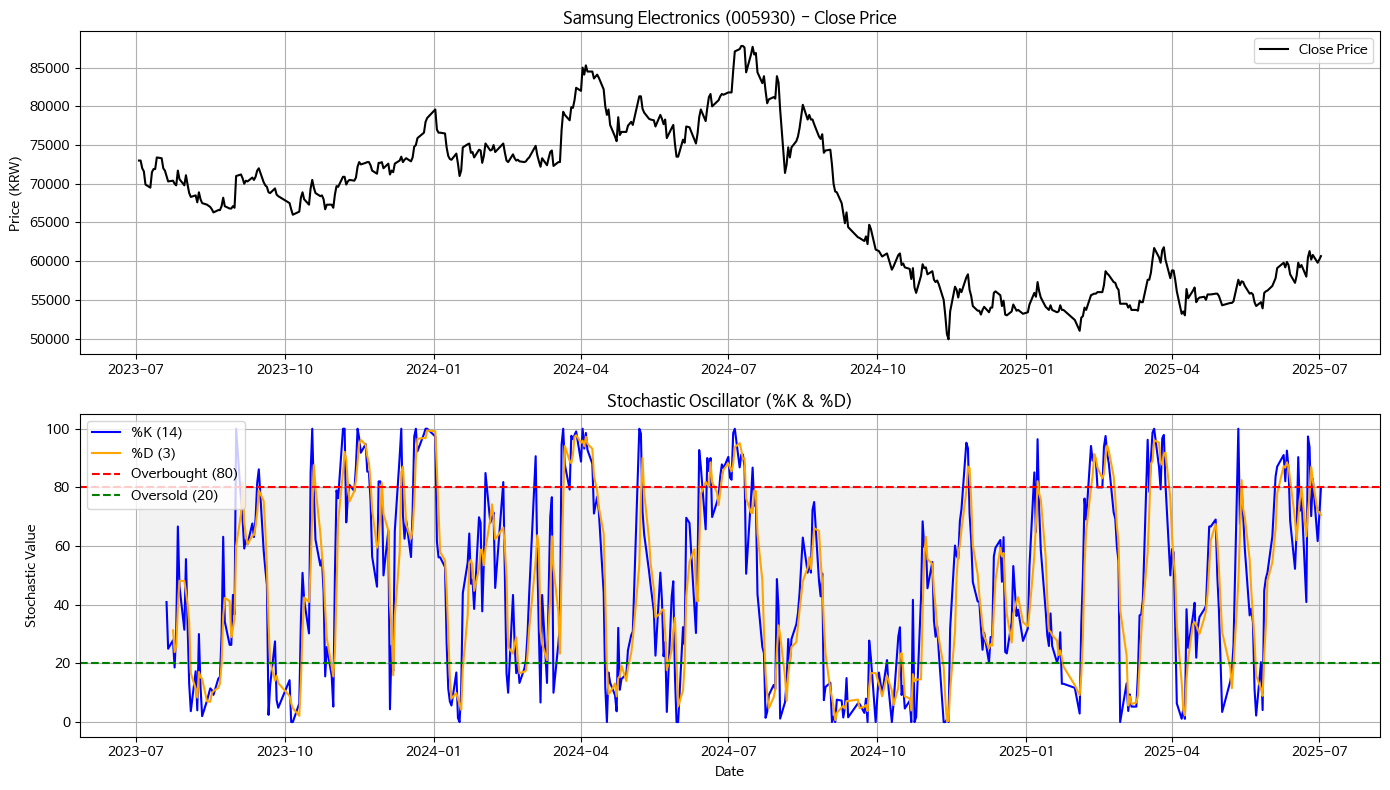

In [2]:
#### from pykrx import stock
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from pykrx import stock
# 1. 날짜 범위 설정 (최근 2년)
end_date = datetime.today().strftime('%Y%m%d')
start_date = (datetime.today() - timedelta(days=2*365)).strftime('%Y%m%d')

# 2. 삼성전자 시세 데이터 가져오기
df = stock.get_market_ohlcv_by_date(start_date, end_date, "005930")
df.index = pd.to_datetime(df.index)

# 3. 스토캐스틱 오실레이터 계산
n = 14  # 기간 설정
low_min = df['저가'].rolling(window=n).min()
high_max = df['고가'].rolling(window=n).max()
df['%K'] = (df['종가'] - low_min) / (high_max - low_min) * 100
df['%D'] = df['%K'].rolling(window=3).mean()  # 3일 이동평균선

# 4. 시각화
plt.figure(figsize=(14, 8))

# (1) 종가 그래프
plt.subplot(2, 1, 1)
plt.plot(df.index, df['종가'], label='Close Price', color='black')
plt.title('Samsung Electronics (005930) - Close Price')
plt.ylabel('Price (KRW)')
plt.grid(True)
plt.legend()

# (2) 스토캐스틱 %K, %D 그래프
plt.subplot(2, 1, 2)
plt.plot(df.index, df['%K'], label='%K (14)', color='blue')
plt.plot(df.index, df['%D'], label='%D (3)', color='orange')
plt.axhline(80, color='red', linestyle='--', label='Overbought (80)')
plt.axhline(20, color='green', linestyle='--', label='Oversold (20)')
plt.fill_between(df.index, 20, 80, color='gray', alpha=0.1)
plt.title('Stochastic Oscillator (%K & %D)')
plt.xlabel('Date')
plt.ylabel('Stochastic Value')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# 구간	해석 의미
# %K > %D, %K < 20	매수 신호 가능성 (과매도에서 반등 시점)
# %K < %D, %K > 80	매도 신호 가능성 (과매수에서 하락 시점)

스토캐스틱 오실레이터(%K, %D)를 활용해 매매 시점을 자동으로 탐지하고,
실제 매수/매도 시점 기준으로 수익률을 계산하는 백테스트

In [ ]:
# 조건	설명
# 📈 매수 시점	%K가 20 아래이고, %K가 %D를 상향 돌파
# 📉 매도 시점	%K가 80 이상이고, %K가 %D를 하향 돌파
# 🎯 수익률 계산	매수 후 첫 매도 시까지 보유한 후 수익률 계산
# 💸 수수료 없음 (원하시면 추가 가능)	

총 거래 횟수: 7
평균 수익률: 1.80%
누적 수익률: 4.83%


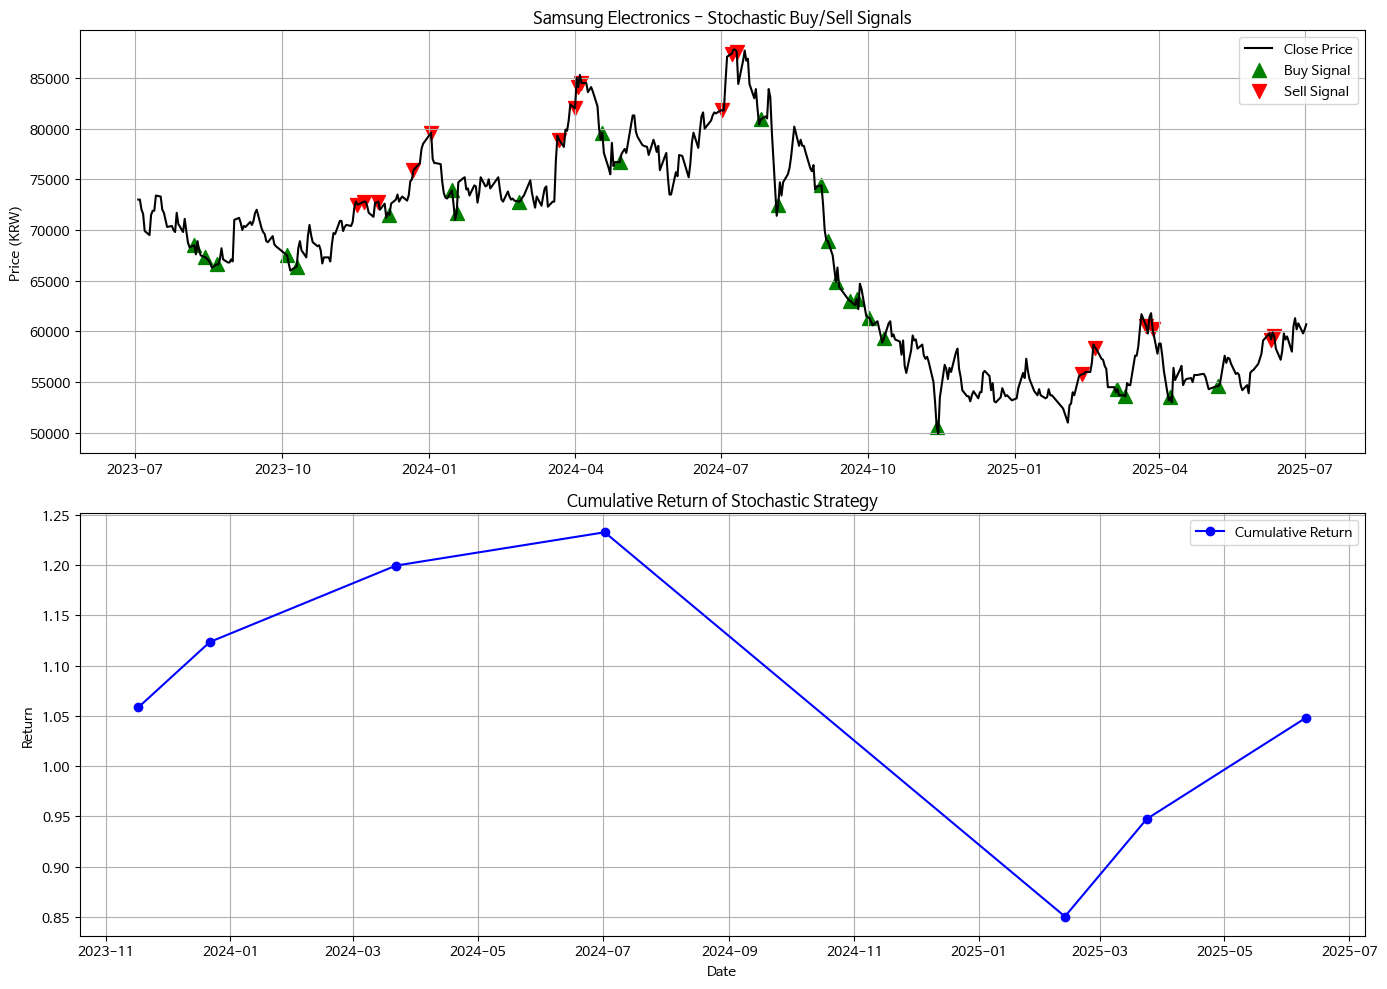

In [3]:
from pykrx import stock
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# 1. 데이터 가져오기
end_date = datetime.today().strftime('%Y%m%d')
start_date = (datetime.today() - timedelta(days=2*365)).strftime('%Y%m%d')
df = stock.get_market_ohlcv_by_date(start_date, end_date, "005930")
df.index = pd.to_datetime(df.index)

# 2. 스토캐스틱 계산
n = 14
low_min = df['저가'].rolling(window=n).min()
high_max = df['고가'].rolling(window=n).max()
df['%K'] = (df['종가'] - low_min) / (high_max - low_min) * 100
df['%D'] = df['%K'].rolling(window=3).mean()

# 3. 매매 시점 탐지
df['prev_%K'] = df['%K'].shift(1)
df['prev_%D'] = df['%D'].shift(1)

df['Buy'] = (df['prev_%K'] < df['prev_%D']) & (df['%K'] > df['%D']) & (df['%K'] < 20)
df['Sell'] = (df['prev_%K'] > df['prev_%D']) & (df['%K'] < df['%D']) & (df['%K'] > 80)

# 4. 백테스트 실행
trades = []
position = None

for date, row in df.iterrows():
    if position is None and row['Buy']:
        position = {
            'buy_date': date,
            'buy_price': row['종가']
        }
    elif position is not None and row['Sell']:
        position['sell_date'] = date
        position['sell_price'] = row['종가']
        position['return'] = (position['sell_price'] - position['buy_price']) / position['buy_price']
        trades.append(position)
        position = None

results = pd.DataFrame(trades)
if not results.empty:
    results['cum_return'] = (1 + results['return']).cumprod()

# 5. 결과 출력
print("총 거래 횟수:", len(results))
if not results.empty:
    print("평균 수익률: {:.2f}%".format(results['return'].mean() * 100))
    print("누적 수익률: {:.2f}%".format((results['cum_return'].iloc[-1] - 1) * 100))

# 6. 시각화
plt.figure(figsize=(14, 10))

# (1) 종가 + 시그널
plt.subplot(2, 1, 1)
plt.plot(df.index, df['종가'], label='Close Price', color='black')
plt.scatter(df[df['Buy']].index, df[df['Buy']]['종가'], marker='^', color='green', label='Buy Signal', s=100)
plt.scatter(df[df['Sell']].index, df[df['Sell']]['종가'], marker='v', color='red', label='Sell Signal', s=100)
plt.title('Samsung Electronics - Stochastic Buy/Sell Signals')
plt.ylabel('Price (KRW)')
plt.legend()
plt.grid(True)

# (2) 누적 수익률
if not results.empty:
    plt.subplot(2, 1, 2)
    plt.plot(results['sell_date'], results['cum_return'], marker='o', label='Cumulative Return', color='blue')
    plt.title('Cumulative Return of Stochastic Strategy')
    plt.xlabel('Date')
    plt.ylabel('Return')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# 항목	의미
# Buy Signal	과매도 구간에서 %K가 %D를 상향 돌파
# Sell Signal	과매수 구간에서 %K가 %D를 하향 돌파
# Return	한 번의 매수-매도 거래 수익률
# Cumulative Return	누적 수익률 (복리 기준)

### RSI + Bollinger Bands + Stochastic 전략

In [ ]:
# 전략 구성
# 지표	              조건	의미
# RSI(14)	            RSI < 30	과매도 구간 (매수 후보)
# 볼린저 밴드	       종가 < 하단 밴드	하단 돌파 (과매도 확신)
# 스토캐스틱	     %K < 20 AND %K > %D	매수 타이밍 신호
# ▶ 매수 조건	위 조건 모두 만족	
# ▶ 매도 조건	RSI > 70 AND 종가 > 상단 밴드 AND %K < %D	

총 거래 횟수: 0


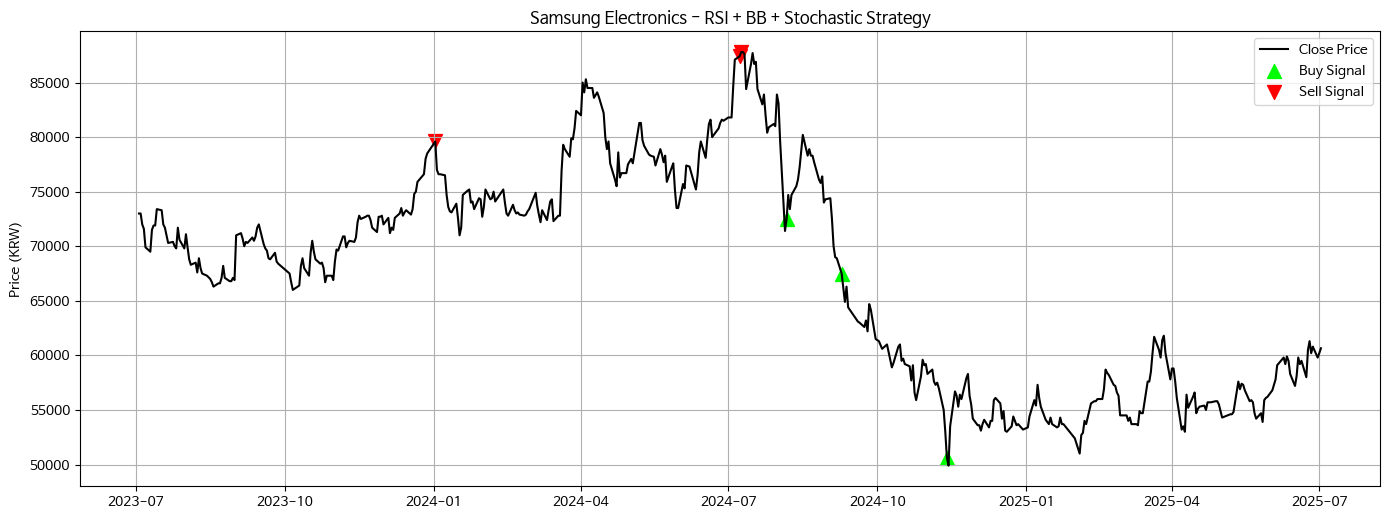

In [4]:
from pykrx import stock
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# 1. 날짜 설정 (2년)
end_date = datetime.today().strftime('%Y%m%d')
start_date = (datetime.today() - timedelta(days=2*365)).strftime('%Y%m%d')

# 2. 삼성전자 데이터
df = stock.get_market_ohlcv_by_date(start_date, end_date, "005930")
df.index = pd.to_datetime(df.index)

# 3. RSI(14)
delta = df['종가'].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)
avg_gain = gain.rolling(14).mean()
avg_loss = loss.rolling(14).mean()
rs = avg_gain / avg_loss
df['RSI'] = 100 - (100 / (1 + rs))

# 4. 볼린저 밴드 (20일)
window = 20
df['MA20'] = df['종가'].rolling(window).mean()
df['STD20'] = df['종가'].rolling(window).std()
df['Upper'] = df['MA20'] + 2 * df['STD20']
df['Lower'] = df['MA20'] - 2 * df['STD20']

# 5. 스토캐스틱 (%K, %D)
n = 14
low_min = df['저가'].rolling(window=n).min()
high_max = df['고가'].rolling(window=n).max()
df['%K'] = (df['종가'] - low_min) / (high_max - low_min) * 100
df['%D'] = df['%K'].rolling(window=3).mean()

df['prev_%K'] = df['%K'].shift(1)
df['prev_%D'] = df['%D'].shift(1)

# 6. 매수/매도 조건
df['Buy'] = (
    (df['RSI'] < 30) &
    (df['종가'] < df['Lower']) &
    (df['%K'] < 20) &
    (df['%K'] > df['%D'])
)

df['Sell'] = (
    (df['RSI'] > 70) &
    (df['종가'] > df['Upper']) &
    (df['%K'] > 80) &
    (df['%K'] < df['%D'])
)

# 7. 백테스트
trades = []
position = None

for date, row in df.iterrows():
    if position is None and row['Buy']:
        position = {'buy_date': date, 'buy_price': row['종가']}
    elif position is not None and row['Sell']:
        position['sell_date'] = date
        position['sell_price'] = row['종가']
        position['return'] = (position['sell_price'] - position['buy_price']) / position['buy_price']
        trades.append(position)
        position = None

results = pd.DataFrame(trades)
if not results.empty:
    results['cum_return'] = (1 + results['return']).cumprod()

# 8. 결과 출력
print("총 거래 횟수:", len(results))
if not results.empty:
    print("평균 수익률: {:.2f}%".format(results['return'].mean() * 100))
    print("누적 수익률: {:.2f}%".format((results['cum_return'].iloc[-1] - 1) * 100))

# 9. 시각화
plt.figure(figsize=(14, 10))

# (1) 종가 + 매매 시점
plt.subplot(2, 1, 1)
plt.plot(df.index, df['종가'], label='Close Price', color='black')
plt.scatter(df[df['Buy']].index, df[df['Buy']]['종가'], marker='^', color='lime', label='Buy Signal', s=100)
plt.scatter(df[df['Sell']].index, df[df['Sell']]['종가'], marker='v', color='red', label='Sell Signal', s=100)
plt.title('Samsung Electronics - RSI + BB + Stochastic Strategy')
plt.ylabel('Price (KRW)')
plt.legend()
plt.grid(True)

# (2) 누적 수익률
if not results.empty:
    plt.subplot(2, 1, 2)
    plt.plot(results['sell_date'], results['cum_return'], marker='o', label='Cumulative Return', color='blue')
    plt.title('Cumulative Return (복합 전략)')
    plt.xlabel('Date')
    plt.ylabel('Return')
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()


### 복합 전략 + 수수료 반영 백테스트

In [ ]:
## 0.3%의 매수·매도 수수료(총 0.6%)를 반영

총 거래 횟수: 0


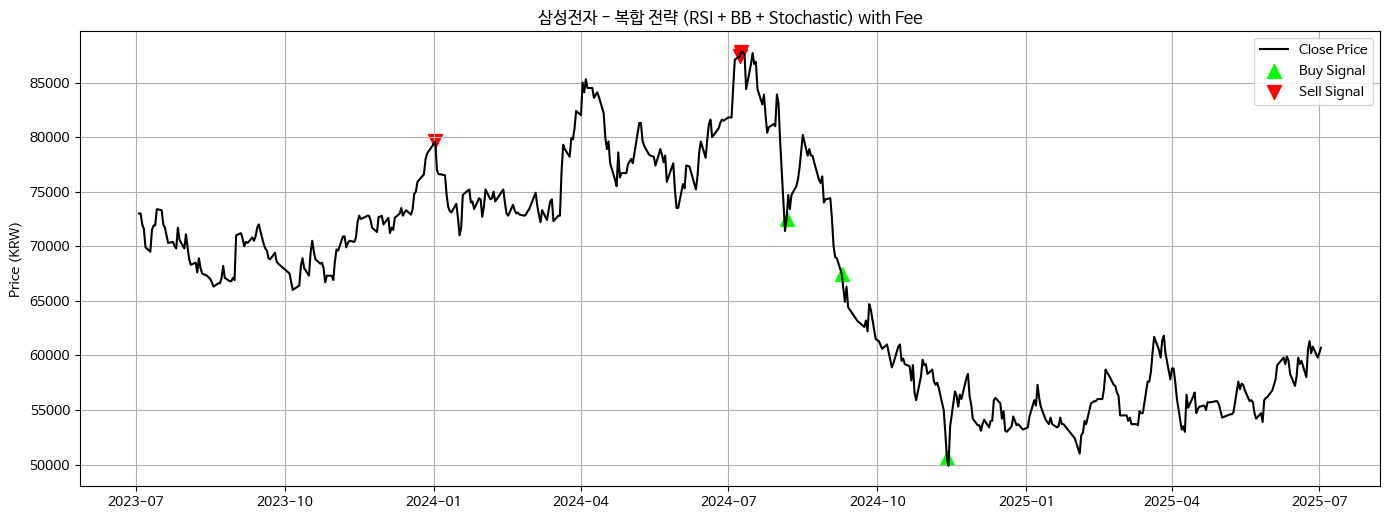

In [5]:
from pykrx import stock
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# 1. 날짜 설정
end_date = datetime.today().strftime('%Y%m%d')
start_date = (datetime.today() - timedelta(days=2*365)).strftime('%Y%m%d')

# 2. 삼성전자 데이터
df = stock.get_market_ohlcv_by_date(start_date, end_date, "005930")
df.index = pd.to_datetime(df.index)

# 3. 기술지표 계산: RSI, 볼린저 밴드, 스토캐스틱
# RSI
delta = df['종가'].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)
avg_gain = gain.rolling(14).mean()
avg_loss = loss.rolling(14).mean()
rs = avg_gain / avg_loss
df['RSI'] = 100 - (100 / (1 + rs))

# 볼린저 밴드
window = 20
df['MA20'] = df['종가'].rolling(window).mean()
df['STD20'] = df['종가'].rolling(window).std()
df['Upper'] = df['MA20'] + 2 * df['STD20']
df['Lower'] = df['MA20'] - 2 * df['STD20']

# 스토캐스틱
n = 14
low_min = df['저가'].rolling(window=n).min()
high_max = df['고가'].rolling(window=n).max()
df['%K'] = (df['종가'] - low_min) / (high_max - low_min) * 100
df['%D'] = df['%K'].rolling(window=3).mean()
df['prev_%K'] = df['%K'].shift(1)
df['prev_%D'] = df['%D'].shift(1)

# 4. 매수/매도 조건
df['Buy'] = (
    (df['RSI'] < 30) &
    (df['종가'] < df['Lower']) &
    (df['%K'] < 20) & (df['%K'] > df['%D'])
)

df['Sell'] = (
    (df['RSI'] > 70) &
    (df['종가'] > df['Upper']) &
    (df['%K'] > 80) & (df['%K'] < df['%D'])
)

# 5. 백테스트 (수수료 0.3% 반영)
fee = 0.003
trades = []
position = None

for date, row in df.iterrows():
    if position is None and row['Buy']:
        position = {
            'buy_date': date,
            'buy_price': row['종가'] * (1 + fee)
        }
    elif position is not None and row['Sell']:
        sell_price = row['종가'] * (1 - fee)
        position['sell_date'] = date
        position['sell_price'] = sell_price
        position['return'] = (sell_price - position['buy_price']) / position['buy_price']
        trades.append(position)
        position = None

results = pd.DataFrame(trades)
if not results.empty:
    results['cum_return'] = (1 + results['return']).cumprod()

# 6. 출력 결과
print("총 거래 횟수:", len(results))
if not results.empty:
    print("평균 수익률 (수수료 포함): {:.2f}%".format(results['return'].mean() * 100))
    print("누적 수익률 (수수료 포함): {:.2f}%".format((results['cum_return'].iloc[-1] - 1) * 100))

# 7. 시각화
plt.figure(figsize=(14, 10))

# (1) 종가 및 시그널 표시
plt.subplot(2, 1, 1)
plt.plot(df.index, df['종가'], label='Close Price', color='black')
plt.scatter(df[df['Buy']].index, df[df['Buy']]['종가'], marker='^', color='lime', label='Buy Signal', s=100)
plt.scatter(df[df['Sell']].index, df[df['Sell']]['종가'], marker='v', color='red', label='Sell Signal', s=100)
plt.title('삼성전자 - 복합 전략 (RSI + BB + Stochastic) with Fee')
plt.ylabel('Price (KRW)')
plt.legend()
plt.grid(True)

# (2) 누적 수익률
if not results.empty:
    plt.subplot(2, 1, 2)
    plt.plot(results['sell_date'], results['cum_return'], marker='o', color='blue', label='Cumulative Return')
    plt.title('누적 수익률 (0.3% 수수료 포함)')
    plt.xlabel('Date')
    plt.ylabel('Return')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


## 2. Stochastic Slow (삼성전자)

In [ ]:
# 스토캐스틱 슬로우는 기존 스토캐스틱 패스트의 변동성을 줄이기 위해 만든 평균 기반 완화 지표입니다.
# 주요 구성
# 이름	설명
# %K_fast	기본 스토캐스틱 %K
# %K_slow	%K_fast의 3일 이동평균
# %D_slow	%K_slow의 3일 이동평균 (시그널선)

In [ ]:
# 해석 포인트
# %K_slow < 20: 과매도로 반등 가능성
# %K_slow > 80: 과매수로 하락 가능성
# %K_slow > %D_slow: 매수 신호
# %K_slow < %D_slow: 매도 신호

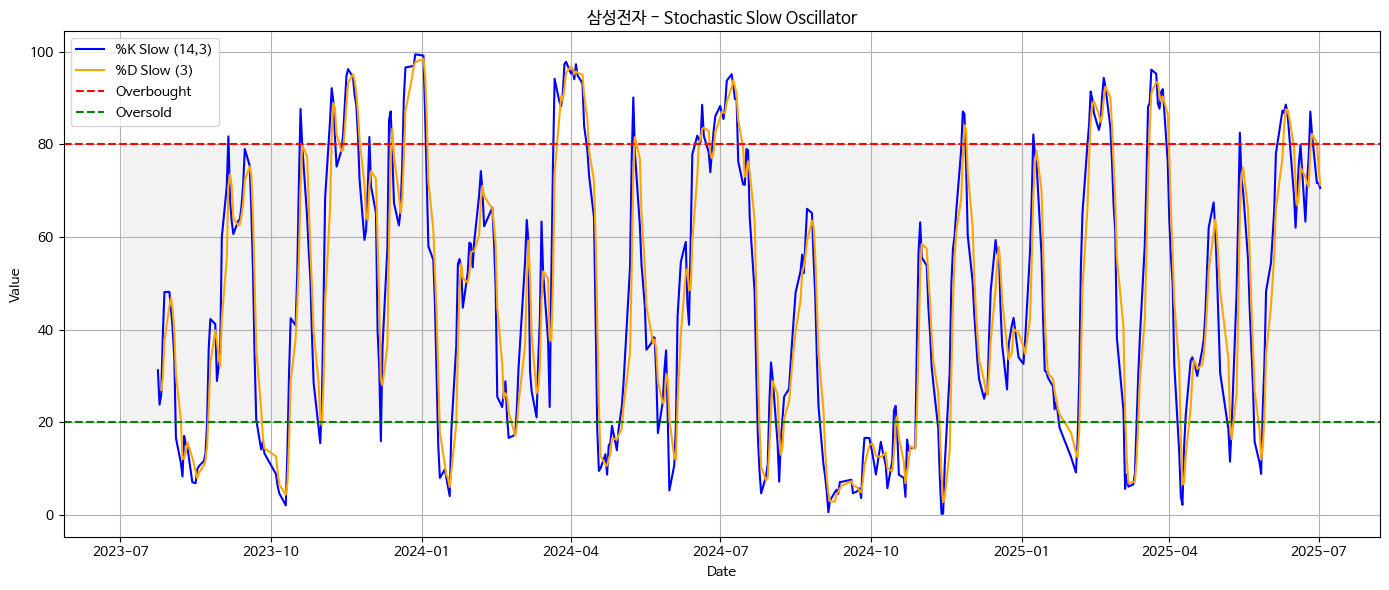

In [7]:
from pykrx import stock
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# 1. 날짜 범위 설정
end_date = datetime.today().strftime('%Y%m%d')
start_date = (datetime.today() - timedelta(days=2*365)).strftime('%Y%m%d')

# 2. 삼성전자 데이터
df = stock.get_market_ohlcv_by_date(start_date, end_date, "005930")
df.index = pd.to_datetime(df.index)

# 3. 스토캐스틱 슬로우 계산 (%K: 14, %D: 3, Slow %D: 3)
low_min = df['저가'].rolling(window=14).min()
high_max = df['고가'].rolling(window=14).max()
df['%K_fast'] = (df['종가'] - low_min) / (high_max - low_min) * 100
df['%K_slow'] = df['%K_fast'].rolling(window=3).mean()
df['%D_slow'] = df['%K_slow'].rolling(window=3).mean()

# 4. 시각화
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['%K_slow'], label='%K Slow (14,3)', color='blue')
plt.plot(df.index, df['%D_slow'], label='%D Slow (3)', color='orange')
plt.axhline(80, color='red', linestyle='--', label='Overbought')
plt.axhline(20, color='green', linestyle='--', label='Oversold')
plt.fill_between(df.index, 20, 80, color='gray', alpha=0.1)
plt.title('삼성전자 - Stochastic Slow Oscillator')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


###  매매 시점 자동 탐지 및 백테스트 

In [ ]:
# 전략 정의
# 조건 구분	기준	설명
# 매수	%K_slow < 20 AND %K_slow > %D_slow	과매도 + 골든크로스
# 매도	%K_slow > 80 AND %K_slow < %D_slow	과매수 + 데드크로스

In [ ]:
# 전체 코드 (수수료 0.3% 반영)

총 거래 횟수: 6
평균 수익률: -0.31%
누적 수익률: -8.82%


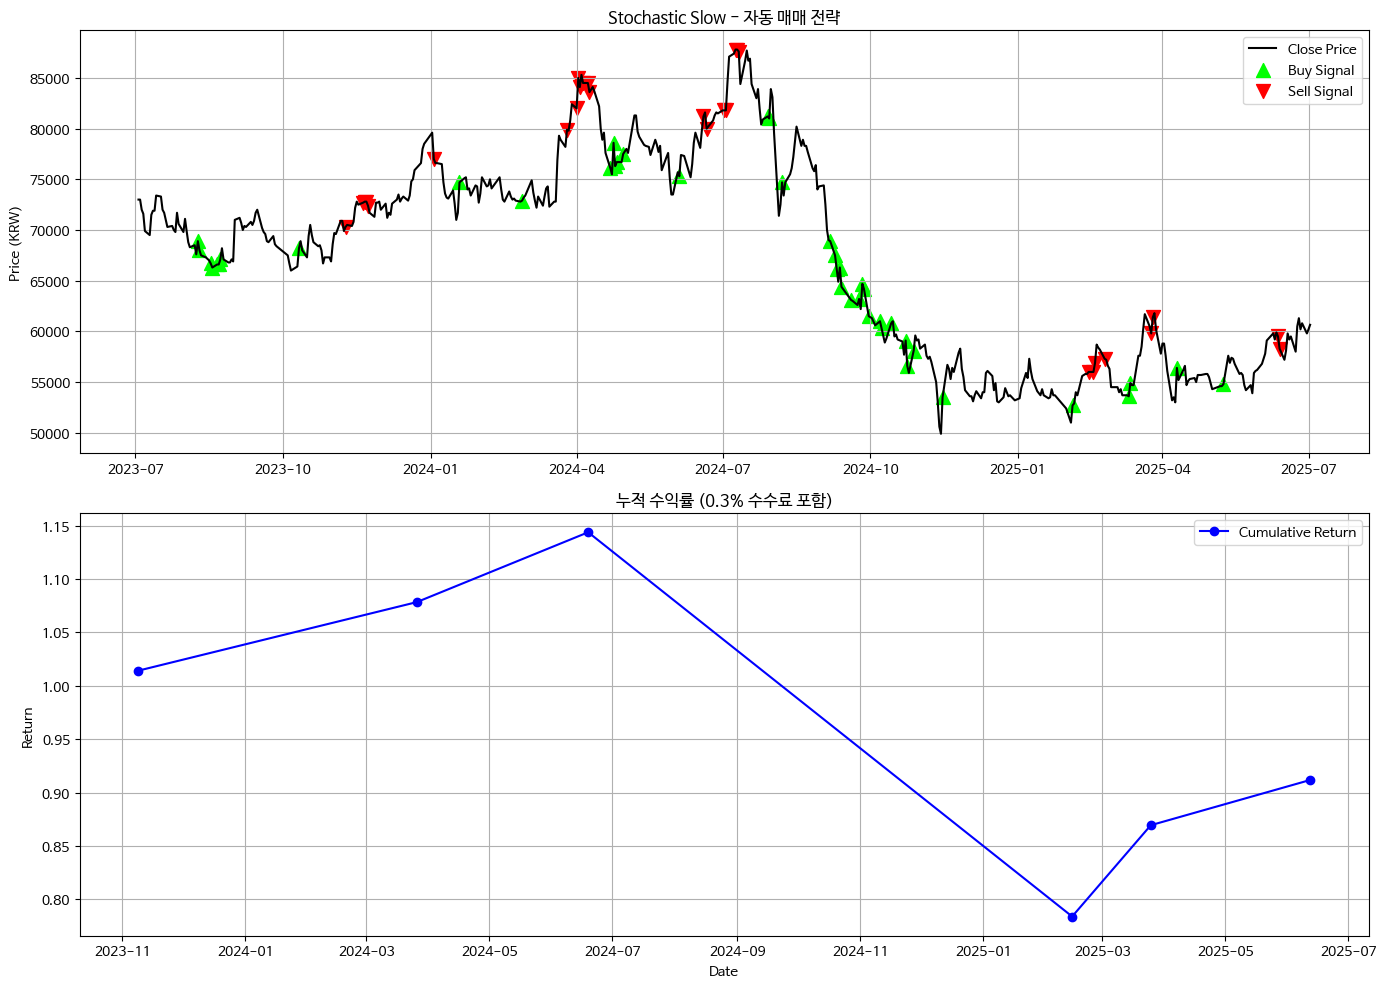

In [8]:
from pykrx import stock
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# 1. 날짜 설정
end_date = datetime.today().strftime('%Y%m%d')
start_date = (datetime.today() - timedelta(days=2*365)).strftime('%Y%m%d')

# 2. 삼성전자 시세 데이터
df = stock.get_market_ohlcv_by_date(start_date, end_date, "005930")
df.index = pd.to_datetime(df.index)

# 3. 스토캐스틱 슬로우 계산
n = 14
low_min = df['저가'].rolling(window=n).min()
high_max = df['고가'].rolling(window=n).max()
df['%K_fast'] = (df['종가'] - low_min) / (high_max - low_min) * 100
df['%K_slow'] = df['%K_fast'].rolling(window=3).mean()
df['%D_slow'] = df['%K_slow'].rolling(window=3).mean()

# 4. 매수/매도 조건 정의
df['Buy'] = (df['%K_slow'] < 20) & (df['%K_slow'] > df['%D_slow'])
df['Sell'] = (df['%K_slow'] > 80) & (df['%K_slow'] < df['%D_slow'])

# 5. 백테스트 실행 (수수료 0.3% 반영)
fee = 0.003
position = None
trades = []

for date, row in df.iterrows():
    if position is None and row['Buy']:
        position = {'buy_date': date, 'buy_price': row['종가'] * (1 + fee)}
    elif position is not None and row['Sell']:
        sell_price = row['종가'] * (1 - fee)
        position['sell_date'] = date
        position['sell_price'] = sell_price
        position['return'] = (sell_price - position['buy_price']) / position['buy_price']
        trades.append(position)
        position = None

results = pd.DataFrame(trades)
if not results.empty:
    results['cum_return'] = (1 + results['return']).cumprod()

# 6. 출력 결과
print("총 거래 횟수:", len(results))
if not results.empty:
    print("평균 수익률: {:.2f}%".format(results['return'].mean() * 100))
    print("누적 수익률: {:.2f}%".format((results['cum_return'].iloc[-1] - 1) * 100))

# 7. 시각화
plt.figure(figsize=(14, 10))

# (1) 종가 + 시그널
plt.subplot(2, 1, 1)
plt.plot(df.index, df['종가'], label='Close Price', color='black')
plt.scatter(df[df['Buy']].index, df[df['Buy']]['종가'], marker='^', color='lime', label='Buy Signal', s=100)
plt.scatter(df[df['Sell']].index, df[df['Sell']]['종가'], marker='v', color='red', label='Sell Signal', s=100)
plt.title('Stochastic Slow - 자동 매매 전략')
plt.ylabel('Price (KRW)')
plt.legend()
plt.grid(True)

# (2) 누적 수익률
if not results.empty:
    plt.subplot(2, 1, 2)
    plt.plot(results['sell_date'], results['cum_return'], marker='o', color='blue', label='Cumulative Return')
    plt.title('누적 수익률 (0.3% 수수료 포함)')
    plt.xlabel('Date')
    plt.ylabel('Return')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# Buy: %K_slow < 20 이면서 %K_slow가 %D_slow를 상향 돌파 → 매수
# Sell: %K_slow > 80 이면서 %K_slow가 %D_slow를 하향 돌파 → 매도
# return: 매수~매도 단일 거래 수익률 (수수료 포함)
# cum_return: 복리 누적 수익률